In [1]:
import numpy as np
import pickle as pkl

from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt

from scipy.linalg import eigh

In [2]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from skimage import exposure
from skimage.transform import resize

from sklearn.model_selection import train_test_split
import copy 

# Utility functions

In [3]:
def reconstructImage(data):

    rows = data.values
    
    nb, N = rows.shape
    red_channel = rows[:,:N//3]
    min_red = red_channel.min(1).reshape(-1,1)
    max_red = red_channel.max(1).reshape(-1,1)
    red_channel = (red_channel-min_red)/(max_red-min_red)

    green_channel = rows[:,N//3:2*N//3]
    min_green = green_channel.min(1).reshape(-1,1)
    max_green = green_channel.max(1).reshape(-1,1)
    green_channel = (green_channel-min_green)/(max_green-min_green)

    blue_channel = rows[:,2*N//3:]
    min_blue = blue_channel.min(1).reshape(-1,1)
    max_blue = blue_channel.max(1).reshape(-1,1)
    blue_channel = (blue_channel-min_blue)/(max_blue-min_blue)

    newdata = np.hstack((red_channel,green_channel,blue_channel))
    newdata = newdata.reshape(nb,3,32,32).transpose(0,2,3,1)
    return newdata

def plot_image(data, index):

    row = data.iloc[index].values
    N = row.shape[0]
    red_channel = row[:N//3].reshape(-1,1)
    min_value = red_channel.min()
    max_value = red_channel.max()
    red_channel = np.array(1*(red_channel - min_value)/(max_value-min_value))
    
    green_channel = row[N//3:2*N//3].reshape(-1,1)
    min_value = green_channel.min()
    max_value = green_channel.max()

    
    green_channel = np.array(1*(green_channel - min_value)/(max_value-min_value))


    blue_channel = row[2*N//3:].reshape(-1,1)
    min_value = blue_channel.min()
    max_value = blue_channel.max()
    blue_channel = np.array(1*(blue_channel - min_value)/(max_value-min_value))
    

    image = np.hstack((red_channel,green_channel,blue_channel))
    image = image.reshape(32,32,3)
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    
def create_Submissioncsv(y_test):

    f = open("result/submission.csv", "w")
    f.write("Id,Prediction\n")
    for n in range(len(y_test)):
        f.write("{},{}\n".format(int(n+1),y_test[n]))
    f.close()
    
def scaler(X_train, X_val = None, X_test = None):
    
    mu_X = X_train.mean()
    sigma_X = X_train.std()
        
    return (X_train - mu_X)/sigma_X, (X_val - mu_X)/sigma_X, (X_test - mu_X)/sigma_X 

# Load the data

In [4]:
import pandas as pd

In [5]:
X_train = pd.read_csv('dataset/Xtr.csv', header = None, sep=',', usecols = range(3072))
X_test = pd.read_csv('dataset/Xte.csv', header = None, sep=',', usecols = range(3072))
Y_train = pd.read_csv('dataset/Ytr.csv')

In [6]:
X_train.shape

(5000, 3072)

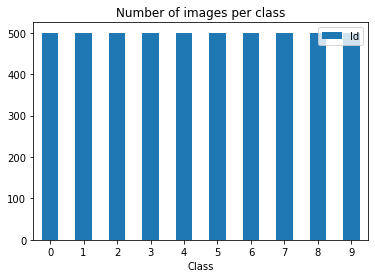

In [7]:
Y_train.groupby('Prediction').count().plot(title = 'Number of images per class',kind='bar', xlabel = 'Class', rot = 0)
plt.show()

# Split the data

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25)

In [9]:
#X_train, X_val, X_test = scaler(X_train, X_val, X_test)

# Visualize the data

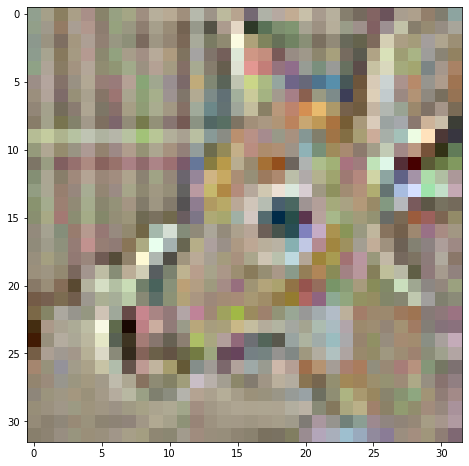

In [10]:
newdata_train = reconstructImage(X_train)
newdata_val = reconstructImage(X_val)
newdata_test = reconstructImage(X_test)

plt.figure(figsize=(8,8))
plt.imshow(newdata_train[0])
plt.show()

# Kernel

In [11]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        N, d = X.shape 
        M, _ = Y.shape
        X = X.reshape(N,1,d,1)
        Y = Y.reshape(1,M,d,1)
        G = ((X-Y).transpose((0, 1, 3, 2))@(X-Y)).reshape(N,M)
        return np.exp(-G/(2*self.sigma**2))
    
class Linear:
    def __init__(self): 
        self = self
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X @ Y.T
    
class Polynomial:
    def __init__(self, d = 3, cst = 0):
        self.d = d  ## the degree of the polynomial
        self.cst = cst  ## trading parameter
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.power(X @ Y.T + self.cst,self.d)

In [12]:
class KernelPCA:
    def __init__(self, kernel, n_components = 10):
        self.kernel = kernel
        self.n_components = n_components
        
    def fit(self, X_train):
        
       #### You might define here any variable needed for the rest of the code  
        
        K = self.kernel(X_train,X_train)
        N = K.shape[0]
        
        # Center the gram matrix
        U = np.ones((N,N))/N
        Kc = (np.eye(N) - U)@K@(np.eye(N) - U)
        
        # Eigenvectors computations
        eigenvals, eigenvects = eigh(Kc)
        eigenvects = eigenvects.T
        
        eigenvals = eigenvals[::-1]   # sorting in descending order
        eigenvects = eigenvects[::-1]
        
        index = np.where(eigenvals>0) # keep only eigenvectors related to positive eigenvalues
        eigenvals = eigenvals[index]
        eigenvects = eigenvects[:,index].squeeze()
        
        # Normalization
        eigenvects = eigenvects / np.sqrt(eigenvals)
        
        # Projection 
        return np.dot(K,eigenvects)[:,:self.n_components]

In [13]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
        self.diag = None

    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X)
        y_diag = np.diag(y)
        
        # Lagrange dual problem
        def loss(alpha):
            #'''--------------dual loss ------------------ '''
            return - alpha.sum() + 0.5 * alpha.T @ y_diag @ K @ y_diag @ alpha

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            # '''----------------partial derivative of the dual loss wrt alpha-----------------'''
            return - np.ones(N) + y_diag @ K @ y_diag @ alpha


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: (0 - y.T @ alpha).reshape(1,1) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  - y #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
    
        fun_ineq = lambda alpha:  self.C*np.vstack((np.ones((N,1)),np.zeros((N,1)))) - (np.vstack((np.eye(N),-np.eye(N)))@alpha).reshape(2*N,1) # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:   - np.vstack((np.eye(N),-np.eye(N))) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
            
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)

        self.alpha = optRes.x 
        ## Assign the required attributes
        
        # Support vectors on the margin
        supportIndices = np.logical_and(self.alpha>self.epsilon, self.alpha<self.C-self.epsilon)
        self.support = X[supportIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        
        self.b = (y - y_diag @ self.alpha @ K)[supportIndices].mean() #''' -----------------offset of the classifier------------------ '''
        self.norm_f = np.sqrt(self.alpha.T @ y_diag @ K @ y_diag @ self.alpha) # '''------------------------RKHS norm of the function f ------------------------------'''
        
        # Support vectors & intermediate variable 
        # for computing the separating function
        self.X_sp = X[np.where(self.alpha>self.epsilon)]
        self.diag = np.diag(y[np.where(self.alpha>self.epsilon)])@ self.alpha[np.where(self.alpha>self.epsilon)]

    ### Implementation of the separating function $f$
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.diag.T @ self.kernel(self.X_sp,x)
    
    
    def predict(self, X):
        """ Predict y values in {label1, label2} """
        d = self.separating_function(X)
        return 2*(d+self.b > 0) - 1

In [23]:
########### ONE versus ONE #############

class MultClassSVMClassifier_OvO(object):
    
    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
        self.classifiers = []
    
    def fit(self, X_train, y_train):

        self.nclasses = np.unique(y_train).size
        labels = np.unique(y_train)
        
        # creation of n(n-1)/2 classifiers
        for i in range(self.nclasses):
            for j in range(i+1, self.nclasses):
                
                svm = KernelSVC(C = self.C, kernel = self.kernel)
                
                # keep only labels i and j for binary classification
                indexes = np.logical_or(y_train == labels[i],y_train == labels[j])
                y_tr = np.where(y_train[indexes] == labels[i],1,-1)
                
                svm.fit(X_train[indexes], y_tr)
                self.classifiers.append([svm,labels[i],labels[j]])
                print(i,j)
                
    def predict(self, X_test):
        predicts = np.zeros((X_test.shape[0], self.nclasses))
        i = 0
        for [classifier,label1, label2] in self.classifiers:
            
            pred = classifier.predict(X_test)
            predicts[np.where(pred == 1),label1] +=1
            predicts[np.where(pred == -1),label2] +=1
            print(i)
            i+=1
        return np.argmax(predicts, axis = 1)
    
########### ONE versus ALL #############
    
class MultClassSVMClassifier_OvA(object):
     
    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
        self.classifiers = []
    
    def fit(self, X_train, y_train):

        self.nclasses = np.unique(y_train).size
        labels = np.unique(y_train)
        
        # creation of n classifiers
        for i in range(self.nclasses):
            
            svm = KernelSVC(C = self.C, kernel = self.kernel)
            y_tr = np.where(y_train == labels[i], 1, -1)
            svm.fit(X_train, y_tr)
            self.classifiers.append(svm)
                
    def predict(self, X_test):
        predicts = np.zeros((X_test.shape[0], self.nclasses))
        
        for count, classifier in enumerate(self.classifiers):
            
            # compute the score for each classifier
            predicts[:,count] = classifier.separating_function(X_test) + classifier.b
            
        return np.argmax(predicts, axis = 1)

# Hog features

In [15]:
def grad_image(image):
    H = 32
    W = 32
    grad_x = np.zeros((H,W,3))
    grad_y = np.zeros((H,W,3))
    #Contour
    #col = x, row = y
    grad_x[:,0,:] = 0
    grad_x[:,-1,:] = 0
    grad_y[0,:,:] = 0
    grad_y[-1,:,:] = 0
    
    #true image, discrete derivative 
    grad_x[:,1:-1,:] = image[:,2:,:] - image[:,:-2,:]
    grad_y[1:-1,:,:] = image[2:,:,:] - image[:-2,:,:]
    
    return grad_x, grad_y

In [16]:
def update_cell_hog(magnitude, orientation, orientation_start, orientation_end):
    tot = 0.
    for i in range(8):
        for j in range(8):
            if (orientation[i, j] >= orientation_start) or (orientation[i, j] < orientation_end):
                continue
            tot += magnitude[i, j]
    return tot / (8 * 8)

In [17]:
def orient_hist(magnitude,orient_hist, c_col, c_row, s_col, s_row, n_cells_row,n_cells_col,orientations):
    hist = np.zeros((n_cells_row, n_cells_col, orientations))
    r_0 = c_row / 2
    c_0 = c_col / 2
    cc = c_row * n_cells_row
    cr = c_col * n_cells_col
    range_rows_stop = (c_row + 1) / 2
    range_rows_start = -(c_row / 2)
    range_columns_stop = (c_col + 1) / 2
    range_columns_start = -(c_col / 2)
    
    for i in range(orientations):
            orientation_start = 180 * (i + 1) / orientations
            orientation_end = 180 * i / orientations
            c = c_0
            r = r_0
            r_i = 0
            c_i = 0

            while r < cc:
                c_i = 0
                c = c_0

                while c < cr:
                    block_magnitude = magnitude[int(r+range_rows_start):int(r+range_rows_stop), int(c+range_columns_start):int(c+range_columns_stop)]
                    block_orientation =  orient_hist[int(r+range_rows_start):int(r+range_rows_stop), int(c+range_columns_start):int(c+range_columns_stop)]
                    hist[r_i, c_i, i] = update_cell_hog(block_magnitude, block_orientation, orientation_start, orientation_end)
                    
                    c_i += 1
                    c += c_col

                r_i += 1
                r += c_row
    return hist

In [18]:
def hog(image):
    eps=1e-5
    
    #Supposed image is size 32x32
    H = 32
    W = 32
    grad_x, grad_y = grad_image(image)
    magn = np.zeros(grad_x.shape)
    for pix in range(3):
        magn[:,:,pix] = np.sqrt(grad_x[:,:,pix]**2 + grad_y[:,:,pix]**2)
    
    #We take those with highest magnitude
    idcs_max = magn.argmax(axis=2)
    rr, cc = np.meshgrid(np.arange(image.shape[0]),np.arange(image.shape[1]),indexing='ij',sparse=True)
    g_row = grad_y[rr, cc, idcs_max]
    g_col = grad_x[rr, cc, idcs_max]
    
    s_row, s_col = image.shape[:2]
    c_row, c_col = (8, 8) #pixels_per_cell
    b_row, b_col = (1, 1) #cells_per_block
    
    n_cells_row = int(s_row // c_row)  # number of cells along row-axis
    n_cells_col = int(s_col // c_col)  # number of cells along col-axis
    
    #Compute orientation histogram
    orientations=9
    orientation_histogram = np.zeros((n_cells_row, n_cells_col, orientations))
    angle = np.arctan2(grad_y , grad_x)
    orientation_histogram = np.rad2deg(angle) % 180
    new_magn = magn[rr, cc, idcs_max]
    new_orient  = orientation_histogram[rr, cc, idcs_max]
    
    hist = orient_hist(new_magn, new_orient, c_col, c_row, s_col, s_row, n_cells_row,n_cells_col,orientations)
    
    #n_blocks_row = (n_cells_row - b_row) + 1
    #n_blocks_col = (n_cells_col - b_col) + 1
    #res = np.zeros((n_blocks_row, n_blocks_col, b_row, b_col, orientations))
    
    return hist.ravel()

In [19]:
n_sample = len(newdata_train)
hog_train = np.zeros((n_sample,144))
for i in range(n_sample):
    hog_train[i,:] = hog(newdata_train[i])
    
n_sample = len(newdata_val)
hog_val = np.zeros((n_sample,144))
for i in range(n_sample):
    hog_val[i,:] = hog(newdata_val[i])
    
n_sample = len(newdata_test)
hog_test = np.zeros((n_sample,144))
for i in range(n_sample):
    hog_test[i,:] = hog(newdata_test[i])

In [20]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = SVC(C = 100, gamma = 10)
clf.fit(hog_train, y_train.Prediction)

test = clf.predict(hog_val)

In [21]:
clf.score(hog_val, y_val.Prediction)

0.516

In [ ]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = SVC(C = 20, gamma = 25)
clf.fit(hog_train, y_train.Prediction)

test = clf.predict(hog_val)

In [ ]:
clf.score(hog_val, y_val.Prediction)

# TEST

In [ ]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = SVC(C = 100, gamma = 100)
clf.fit(X_train, y_train.Prediction)

test = clf.predict(X_val)

In [ ]:
test

In [ ]:
clf.score(X_val, y_val.Prediction)

In [ ]:
sigma = np.sqrt(1/25)
C= 20.
kernel = RBF(sigma).kernel
model = MultClassSVMClassifier_OvA(C=C, kernel=kernel)

model.fit(hog_train, y_train.Prediction.values)

In [ ]:
Y_pred = model.predict(hog_val)

In [ ]:
(y_val.Prediction == Y_pred).sum()/y_val.shape[0]

In [33]:
Y_pred = model.predict(hog_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [28]:
create_Submissioncsv(Y_pred)

In [29]:
Y_pred

array([5, 3, 6, ..., 6, 6, 5])

# REFERENCES

[1] Foody, G. M. and Mathur, A., 2004. **A relative evaluation of multi-class image classification by support vector machines**, IEEE Transactions on Geoscience and Remote Sensing, 42, 1335-1343.

[2] Xi, Pengcheng & Xu, Tao. (2004). **De-noising and Recovering Images Based on Kernel PCA Theory..** 197-200. 